# Residual Network(Using GPU)
![SsMqje](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/SsMqje.png)
![QesESW](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/QesESW.png)
![T5wjJD](https://gitee.com/pxqp9W/testmarkdown/raw/master/imgs/2020/07/T5wjJD.png)
- [深入解读残差网络ResNet V1（附源码） - 知乎](https://zhuanlan.zhihu.com/p/47199669)
- [[1512.03385] Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
- [[译] Deep Residual Learning for Image Recognition (ResNet) - 简书](https://www.jianshu.com/p/f71ba99157c7)
- 更多残差块的设计可以参考：[[1603.05027] Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)
- 更多“残差”的网络：[[1608.06993] Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)

In [33]:
import torch 
from torchvision import transforms 
from torchvision import datasets 
from torch.utils.data import DataLoader 
import torch.nn.functional as F 
import torch.optim as optim
import time
import matplotlib.pyplot as plt

## 1、Prepare Dataset

In [34]:
batch_size = 64

## Convert the PIL Image to Tensor.
transform = transforms.Compose([
    transforms.ToTensor(), # 图像转变为ToTensor，取值变为0-1
    transforms.Normalize((0.1307, ), (0.3081, )) 
    # 0.1307是均值mean, 0.3081是标准差std
    # 这两个数是根据 MNIST数据集的特征得到的经验值
])

## 构造loader
train_dataset = datasets.MNIST(root='./dataset/mnist/', 
                               train=True, 
                               download=True, 
                               transform=transform) # transform放入到了数据集中，这样每次取出来的数据都会直接做变换
train_loader = DataLoader(train_dataset, 
                          shuffle=True, 
                          batch_size=batch_size)
test_dataset = datasets.MNIST(root='./dataset/mnist/' , 
                              train=False, 
                              download=True, 
                              transform=transform)
test_loader = DataLoader(test_dataset, 
                         shuffle=False, 
                         batch_size=batch_size)

## 2、Design Model 
### 2.1 构造Residual Block

In [35]:
## Residual Block
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels 
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1) 
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        y = F.relu(self.conv1(x)) 
        y = self.conv2(y) 
        return F.relu(x + y)

## 2.2 构造网络结构

In [36]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__() 
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5) 
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5) 
        self.mp = torch.nn.MaxPool2d(2) 
        
        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)
        
        self.fc = torch.nn.Linear(512, 10) # 88*4*4 = 1408 
    
    def forward(self, x):
        batch_size = x.size(0) 
        x = self.mp(F.relu(self.conv1(x)))
        x = self.rblock1(x)
        x = self.mp(F.relu(self.conv2(x)))
        x = self.rblock2(x) 
        x = x.view(batch_size, -1) 
        # print x size
        # print(x.size()) # torch.Size([64, 1408])
        x = self.fc(x)  # 因为后面要用PyTorch的交叉熵函数，因此最后一层不做激活
        return x
    
model = Net()
## Define device as the first visible cuda device if we have CUDA available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
## Convert parameters and buffers of all modules to CUDA Tensor.
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

## 3、Construct Loss and Optimizer

In [37]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # momentum表示动量

## 4、Train & Test

In [38]:
## 将训练过程封装到函数
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data 
        ## Send the inputs and targets at every step to the GPU.
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        # forward + backward + update
        outputs = model(inputs) 
        loss = criterion(outputs, target) 
        loss.backward() 
        optimizer.step()
        running_loss += loss.item() 
        
        if batch_idx % 300 == 299: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 300)) 
            running_loss = 0.0

In [39]:
## 将测试过程也封装为函数
def test():
    correct = 0 
    total = 0
    with torch.no_grad(): # Test过程中不需要计算梯度，可以使用“with torch.no_grad()”
        for data in test_loader:
            images, labels = data 
            # Send the inputs and targets at every step to the GPU.
            images, labels = images.to(device), labels.to(device)
            outputs = model(images) 
            _, predicted = torch.max(outputs.data, dim=1) # torch.max用来找行中的最大值所在下标 dim1表示沿着第1个维度找（行是第0个维度，列是第1个维度）
            total += labels.size(0) # labels是一个N*1的向量，取size()得到的是元组(N,1),size(0)返回的是N
            correct += (predicted == labels).sum().item() # 预测正确的数量，predicted == labels进行的是张量之间的比较运算
    acc = 100 * correct / total
    print('Accuracy on test set: %d %%' % (acc))
    return acc

## Main Function

In [40]:
epoch_list = []
acc_list = []

In [41]:
if __name__ == '__main__':
    start = time.time()
    for epoch in range(10):
        train(epoch) 
        epoch_list.append(epoch)
        acc_list.append(test())
    end = time.time()
    print("Total time: ", end - start , "s")

[1,   300] loss: 0.515
[1,   600] loss: 0.158
[1,   900] loss: 0.113
Accuracy on test set: 97 %
[2,   300] loss: 0.087
[2,   600] loss: 0.082
[2,   900] loss: 0.068
Accuracy on test set: 97 %
[3,   300] loss: 0.059
[3,   600] loss: 0.059
[3,   900] loss: 0.056
Accuracy on test set: 98 %
[4,   300] loss: 0.045
[4,   600] loss: 0.047
[4,   900] loss: 0.048
Accuracy on test set: 98 %
[5,   300] loss: 0.043
[5,   600] loss: 0.039
[5,   900] loss: 0.040
Accuracy on test set: 98 %
[6,   300] loss: 0.036
[6,   600] loss: 0.032
[6,   900] loss: 0.036
Accuracy on test set: 98 %
[7,   300] loss: 0.034
[7,   600] loss: 0.029
[7,   900] loss: 0.030
Accuracy on test set: 98 %
[8,   300] loss: 0.027
[8,   600] loss: 0.025
[8,   900] loss: 0.028
Accuracy on test set: 98 %
[9,   300] loss: 0.021
[9,   600] loss: 0.029
[9,   900] loss: 0.025
Accuracy on test set: 99 %
[10,   300] loss: 0.019
[10,   600] loss: 0.021
[10,   900] loss: 0.027
Accuracy on test set: 99 %
Total time:  86.42940592765808 s


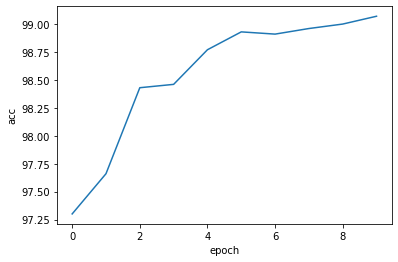

In [42]:
# plot
plt.plot(epoch_list, acc_list) 
plt.xlabel('epoch') 
plt.ylabel('acc')
plt.show()